In [6]:
# Import our dependencies
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib
import optuna
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

#  Import and read the charity_data.csv.

df = pd.read_csv('Resources/cleaned_data.csv', delimiter=',')
df.head()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,50,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,55,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,52,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,48,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,48,1,156,56.00,100,60,1,1,0,0,0,0


# Dataset Exploration

In [2]:
df.shape

(70000, 14)

In [3]:
df.dtypes

id               int64
age_days         int64
age_years        int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [4]:
df.describe()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00
mean,49972.42,19468.87,53.30,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.80,0.50
std,28851.30,2467.25,6.76,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.40,0.50
min,0.00,10798.00,30.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,25006.75,17664.00,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
50%,50001.50,19703.00,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
75%,74889.25,21327.00,58.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.00,1.00
max,99999.00,23713.00,65.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.00,1.00


In [5]:
df.cardio.value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

# Prep Data for Training

In [7]:
# Caluclate BMI (Body Mass Index)

# Convert height from centimeters to meters
df['height_meters'] = df['height'] / 100

# Calculate BMI (weight in kilograms / (height in meters)^2)
df['bmi'] = df['weight'] / (df['height_meters'] ** 2)

In [8]:
# Split our preprocessed data into our features and target arrays
features = df.drop(columns=['cardio', 'age_years', 'id', 'height_meters'])
X = features.values
y = df['cardio'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# LazyPredict

In [5]:
clf = LazyClassifier(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
models

  3%|▎         | 1/29 [00:01<00:31,  1.14s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7347428571428571, 'Balanced Accuracy': 0.7352283979488877, 'ROC AUC': 0.7352283979488877, 'F1 Score': 0.7335557609480395, 'Time taken': 1.1357831954956055}


  7%|▋         | 2/29 [00:03<00:43,  1.60s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6948571428571428, 'Balanced Accuracy': 0.6951835727105764, 'ROC AUC': 0.6951835727105762, 'F1 Score': 0.6942506330576045, 'Time taken': 1.8066580295562744}
{'Model': 'BernoulliNB', 'Accuracy': 0.7112571428571428, 'Balanced Accuracy': 0.7116009978022603, 'ROC AUC': 0.7116009978022603, 'F1 Score': 0.710620955387211, 'Time taken': 0.06767082214355469}


 14%|█▍        | 4/29 [00:03<00:17,  1.42it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6570857142857143, 'Balanced Accuracy': 0.6572786491967675, 'ROC AUC': 0.6572786491967674, 'F1 Score': 0.656856049055803, 'Time taken': 0.28090453147888184}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 28%|██▊       | 8/29 [00:03<00:06,  3.39it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6307428571428572, 'Balanced Accuracy': 0.6307785758412477, 'ROC AUC': 0.6307785758412479, 'F1 Score': 0.6307412414539331, 'Time taken': 0.32597827911376953}
{'Model': 'DummyClassifier', 'Accuracy': 0.4964571428571429, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3294042811320343, 'Time taken': 0.03854012489318848}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.6220571428571429, 'Balanced Accuracy': 0.6220567926375301, 'ROC AUC': 0.6220567926375301, 'F1 Score': 0.6220615708927726, 'Time taken': 0.0782308578491211}


 31%|███       | 9/29 [00:07<00:21,  1.10s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.6966285714285714, 'Balanced Accuracy': 0.6965586752202129, 'ROC AUC': 0.6965586752202129, 'F1 Score': 0.6965939274907755, 'Time taken': 3.875141143798828}
{'Model': 'GaussianNB', 'Accuracy': 0.6004571428571429, 'Balanced Accuracy': 0.6022640731833119, 'ROC AUC': 0.6022640731833119, 'F1 Score': 0.5728942967546995, 'Time taken': 0.052001237869262695}


 38%|███▊      | 11/29 [00:10<00:22,  1.24s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6481714285714286, 'Balanced Accuracy': 0.648291840441922, 'ROC AUC': 0.6482918404419221, 'F1 Score': 0.6480864056736547, 'Time taken': 2.8747177124023438}


 41%|████▏     | 12/29 [03:46<13:33, 47.86s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.6484571428571428, 'Balanced Accuracy': 0.6489399709420186, 'ROC AUC': 0.6489399709420186, 'F1 Score': 0.6468730430650715, 'Time taken': 215.3166947364807}


 48%|████▊     | 14/29 [11:55<28:29, 114.00s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.6486285714285714, 'Balanced Accuracy': 0.6491053343465172, 'ROC AUC': 0.6491053343465173, 'F1 Score': 0.6470857254959924, 'Time taken': 489.1611633300781}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6524571428571428, 'Balanced Accuracy': 0.6527134175396183, 'ROC AUC': 0.6527134175396183, 'F1 Score': 0.6520332556004204, 'Time taken': 0.1691875457763672}


 55%|█████▌    | 16/29 [11:59<13:18, 61.40s/it] 

{'Model': 'LinearSVC', 'Accuracy': 0.6807428571428571, 'Balanced Accuracy': 0.6810187733703161, 'ROC AUC': 0.6810187733703162, 'F1 Score': 0.6802936156718254, 'Time taken': 3.485255479812622}
{'Model': 'LogisticRegression', 'Accuracy': 0.7198857142857142, 'Balanced Accuracy': 0.720189105723068, 'ROC AUC': 0.720189105723068, 'F1 Score': 0.7194117590501203, 'Time taken': 0.1455211639404297}


 59%|█████▊    | 17/29 [11:59<08:51, 44.26s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.6473714285714286, 'Balanced Accuracy': 0.6477760529129456, 'ROC AUC': 0.6477760529129457, 'F1 Score': 0.6462647014564605, 'Time taken': 0.628741979598999}


 69%|██████▉   | 20/29 [29:53<28:00, 186.76s/it]  

{'Model': 'NuSVC', 'Accuracy': 0.6575428571428571, 'Balanced Accuracy': 0.6575536017769172, 'ROC AUC': 0.6575536017769174, 'F1 Score': 0.6575471008577776, 'Time taken': 1073.7578518390656}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.6007428571428571, 'Balanced Accuracy': 0.600587972704223, 'ROC AUC': 0.600587972704223, 'F1 Score': 0.6005443238702609, 'Time taken': 0.0991063117980957}
{'Model': 'Perceptron', 'Accuracy': 0.6213142857142857, 'Balanced Accuracy': 0.6218730903531013, 'ROC AUC': 0.6218730903531013, 'F1 Score': 0.6190022976776793, 'Time taken': 0.0657355785369873}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5908571428571429, 'Balanced Accuracy': 0.5928417552157655, 'ROC AUC': 0.5928417552157655, 'F1 Score': 0.5562848738705063, 'Time taken': 0.07386493682861328}


 83%|████████▎ | 24/29 [29:59<06:07, 73.58s/it] 

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7086285714285714, 'Balanced Accuracy': 0.7086799433887658, 'ROC AUC': 0.708679943388766, 'F1 Score': 0.7086225232412385, 'Time taken': 5.600143671035767}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6524571428571428, 'Balanced Accuracy': 0.6527134175396183, 'ROC AUC': 0.6527134175396183, 'F1 Score': 0.6520332556004204, 'Time taken': 0.06528019905090332}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6524571428571428, 'Balanced Accuracy': 0.6527134175396183, 'ROC AUC': 0.6527134175396183, 'F1 Score': 0.6520332556004204, 'Time taken': 0.07786178588867188}


 86%|████████▌ | 25/29 [29:59<03:54, 58.60s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.7169142857142857, 'Balanced Accuracy': 0.7171924230226822, 'ROC AUC': 0.717192423022682, 'F1 Score': 0.7165147205166691, 'Time taken': 0.1305699348449707}


 90%|████████▉ | 26/29 [31:21<03:11, 63.85s/it]

{'Model': 'SVC', 'Accuracy': 0.7301714285714286, 'Balanced Accuracy': 0.7303773462271856, 'ROC AUC': 0.7303773462271855, 'F1 Score': 0.7299717022732857, 'Time taken': 81.84984302520752}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [31:21<00:38, 38.90s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.7339428571428571, 'Balanced Accuracy': 0.7342299478193557, 'ROC AUC': 0.7342299478193557, 'F1 Score': 0.7335439855090616, 'Time taken': 0.3961794376373291}
[LightGBM] [Info] Number of positive: 26167, number of negative: 26333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 52500, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498419 -> initscore=-0.006324
[LightGBM] [Info] Start training from score -0.006324


100%|██████████| 29/29 [31:22<00:00, 64.90s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7389714285714286, 'Balanced Accuracy': 0.7392409553271154, 'ROC AUC': 0.7392409553271154, 'F1 Score': 0.7386295697846019, 'Time taken': 0.22547006607055664}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.74,0.74,0.74,0.74,0.23
AdaBoostClassifier,0.73,0.74,0.74,0.73,1.14
XGBClassifier,0.73,0.73,0.73,0.73,0.40
SVC,0.73,0.73,0.73,0.73,81.85
LogisticRegression,0.72,0.72,0.72,0.72,0.15
SGDClassifier,0.72,0.72,0.72,0.72,0.13
BernoulliNB,0.71,0.71,0.71,0.71,0.07
RandomForestClassifier,0.71,0.71,0.71,0.71,5.60
ExtraTreesClassifier,0.70,0.70,0.70,0.70,3.88


# Training the Model

### Tuning Hyperparameters

In [ ]:
# Define the objective function

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'objective': 'binary',
        'metric': 'binary_error'
    }
    
    # Initialize and train the model
    model = LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return 1.0 - accuracy 

# Create Optuna study
storage = f"sqlite:///{os.path.join(os.getcwd(), 'Tuning/optuna_study.db')}"
study = optuna.create_study(direction='minimize', study_name='model_tuning_accuracy2', storage=storage)
study.optimize(objective, n_trials=100)


### Training and predicting

In [13]:
# Get the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)

# Train the model with the best hyperparameters
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Save the best model
joblib.dump(best_model, 'final_model/best_model.pkl')

## To load best model use following code
# best_model = joblib.load('final_model/best_model.pkl')

Best hyperparameters: {'learning_rate': 0.0069988272403454605, 'max_depth': 6, 'num_leaves': 122, 'feature_fraction': 0.5455779426886196, 'subsample': 0.9755329819918853, 'n_estimators': 264}
[LightGBM] [Warning] feature_fraction is set=0.5455779426886196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455779426886196
[LightGBM] [Warning] feature_fraction is set=0.5455779426886196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455779426886196
[LightGBM] [Info] Number of positive: 26167, number of negative: 26333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 52500, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498419 -> initscore=-0.0063

['final_model/best_model.pkl']

In [14]:
# Evaluate accuracy on the test set
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

[LightGBM] [Warning] feature_fraction is set=0.5455779426886196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455779426886196
Accuracy: 0.7391428571428571


In [15]:
print(best_params)

{'learning_rate': 0.0069988272403454605, 'max_depth': 6, 'num_leaves': 122, 'feature_fraction': 0.5455779426886196, 'subsample': 0.9755329819918853, 'n_estimators': 264}


### Feature Importances

In [16]:
importances = best_model.feature_importances_
sorted(zip(importances, features.columns), reverse=True)

[(3039, 'age_days'),
 (2555, 'bmi'),
 (2230, 'weight'),
 (1622, 'height'),
 (1476, 'ap_hi'),
 (1307, 'ap_lo'),
 (805, 'cholesterol'),
 (692, 'gluc'),
 (427, 'active'),
 (310, 'smoke'),
 (301, 'gender'),
 (238, 'alco')]

In [17]:
# Normalize feature importances
total_importance = sum(importances)
normalized_importances = importances / total_importance
rounded_importances = np.round(normalized_importances, 3)
sorted(zip(rounded_importances, features.columns), reverse=True)

[(0.203, 'age_days'),
 (0.17, 'bmi'),
 (0.149, 'weight'),
 (0.108, 'height'),
 (0.098, 'ap_hi'),
 (0.087, 'ap_lo'),
 (0.054, 'cholesterol'),
 (0.046, 'gluc'),
 (0.028, 'active'),
 (0.021, 'smoke'),
 (0.02, 'gender'),
 (0.016, 'alco')]

In [18]:
feature_importance_df = pd.DataFrame(rounded_importances, index=features.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance_df

,importance
age_days,0.20
bmi,0.17
weight,0.15
height,0.11
ap_hi,0.10
ap_lo,0.09
cholesterol,0.05
gluc,0.05
active,0.03
smoke,0.02


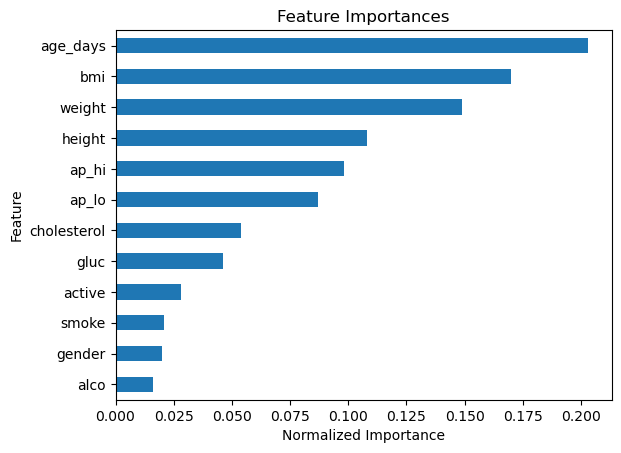

In [19]:
sorted_feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

# Plot normalized feature importances
sorted_feature_importance_df.plot(kind='barh', legend=False)
plt.title('Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()

# Model Performance Analysis

In [20]:
# Print the balanced_accuracy score of the model
print(f'Accuracy score: {balanced_accuracy_score(y_test, y_pred)}')

Accuracy score: 0.7394662466383946


In [21]:
# Generate a confusion matrix for the model
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Confusion Matrix: 
[[6821 1867]
 [2698 6114]]


In [22]:
# Print the classification report for the model
cardio_labels = ['low risk', 'high risk']
print(f'Classification Report: \n{classification_report(y_test, y_pred, target_names=cardio_labels)}')

Classification Report: 
              precision    recall  f1-score   support

    low risk       0.72      0.79      0.75      8688
   high risk       0.77      0.69      0.73      8812

    accuracy                           0.74     17500
   macro avg       0.74      0.74      0.74     17500
weighted avg       0.74      0.74      0.74     17500



## Test on single sample

In [20]:
df.head()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,height_meters,bmi
0,0,18393,50,2,168,62.00,110,80,1,1,0,0,1,0,1.68,21.97
1,1,20228,55,1,156,85.00,140,90,3,1,0,0,1,1,1.56,34.93
2,2,18857,52,1,165,64.00,130,70,3,1,0,0,0,1,1.65,23.51
3,3,17623,48,2,169,82.00,150,100,1,1,0,0,1,1,1.69,28.71
4,4,17474,48,1,156,56.00,100,60,1,1,0,0,0,0,1.56,23.01


In [23]:
med_dict = {'age_days': 18222, 'gender': 2, 'height': 168, 'weight': 62.00, 'ap_hi': 110, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1, 'bmi': 21.97}
sample_df = pd.DataFrame(data=med_dict, index=[0])
sample_df.head()


,age_days,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,18222,2,168,62.00,110,80,1,1,0,0,1,21.97


In [24]:
# Create a StandardScaler instance
sample_scaler = StandardScaler()

# Fit the StandardScaler
X_scaler2 = sample_scaler.fit(sample_df)

# Scale the data
sample_scaled = X_scaler2.transform(sample_df)

In [25]:
sample_prediction = best_model.predict(sample_scaled)
print(sample_prediction)

[LightGBM] [Warning] feature_fraction is set=0.5455779426886196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455779426886196
[0]
